In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('merged_macro_commodity.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df_reset = df.reset_index()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 408 entries, 1991-01-01 to 2024-12-01
Data columns (total 6 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Revenue, excluding grants (% of GDP)           408 non-null    float64
 1   GDP (constant 2015 US$)                        408 non-null    float64
 2   Employment to population ratio (15+, total %)  408 non-null    float64
 3   Crude Oil Brent Price                          408 non-null    float64
 4   Cocoa Price                                    408 non-null    float64
 5   Gold Price                                     408 non-null    float64
dtypes: float64(6)
memory usage: 22.3 KB


In [4]:
# Create separate Prophet models for each commodity
commodity_cols = ['Crude Oil Brent Price', 'Cocoa Price', 'Gold Price']
feature_cols = ['Revenue, excluding grants (% of GDP)', 'GDP (constant 2015 US$)', 
                'Employment to population ratio (15+, total %)']

# Split data into train and test sets (using last 20% for testing)
test_size = int(0.2 * len(df_reset))
train_size = len(df_reset) - test_size

train_df = df_reset.iloc[:train_size]
test_df = df_reset.iloc[train_size:]

In [5]:
# Modified Prophet configuration for monthly data
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # Disabled for monthly data
    daily_seasonality=False,   # Disabled for monthly data
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    interval_width=0.95,
    growth='logistic',  # Prevents negative prices
    mcmc_samples=300 if len(train_df) > 60 else 0  # Only for sufficient data
)

# Crude Oil Brent Price	Cocoa Price	Gold Price
# count	780.000000	780.000000	780.000000
# mean	34.230560	1.839660	581.009694
# std	32.522904	1.139750	586.327299
# min	1.210000	0.259000	34.940000
# 25%	11.510000	1.060550	149.980000
# 50%	22.565000	1.641050	373.980000
# 75%	54.127273	2.383293	889.746250
# max	133.873043	10.320510	2690.080000


# Set realistic bounds for each commodity
commodity_bounds = {
    'Crude Oil Brent Price': {'floor': 20, 'cap': 150},  # Historical range
    'Cocoa Price': {'floor': 1, 'cap': 10},
    'Gold Price': {'floor': 150, 'cap': 2500}
}

for commodity in commodity_cols:
    prophet_df = train_df[['date', commodity]].rename(columns={'date': 'ds', commodity: 'y'})
    bounds = commodity_bounds.get(commodity, {'floor': 0, 'cap': None})
    
    # Set floor and cap
    prophet_df['floor'] = bounds['floor']
    prophet_df['cap'] = bounds['cap'] if bounds['cap'] else prophet_df['y'].max() * 1.5
    
    # Add macroeconomic regressors with 3-month lags
    for feature in feature_cols:
        prophet_df[feature] = train_df[feature].values
        prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values

/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_8379/3450242253.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_8379/3450242253.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_8379/3450242253.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prophet_df[f'{feature}_lag3'] = train_df[feature].shift(3).fillna(method='bfill').values
/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_8379/3450242253.py:44: 

In [6]:
# Add custom monthly seasonality (since default yearly may not capture monthly patterns well)
model.add_seasonality(
    name='monthly',
    period=30.5,  # Average month length
    fourier_order=5  # Moderate complexity
)

# Add quarterly seasonality for commodities
model.add_seasonality(
    name='quarterly',
    period=91.25,  # Average quarter length
    fourier_order=3
)

In [7]:
# Standardize regressors for better convergence
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for feature in feature_cols + [f'{f}_lag3' for f in feature_cols]:
    prophet_df[feature] = scaler.fit_transform(prophet_df[feature].values.reshape(-1, 1))
    
    # Add as regressor with potentially different modes
    if 'GDP' in feature:
        mode = 'multiplicative'
    else:
        mode = 'additive'
    model.add_regressor(feature, mode=mode)

In [8]:
# For each commodity
model.fit(prophet_df)

# Create future dataframe with proper monthly spacing
future = model.make_future_dataframe(periods=test_size, freq='M')

# Add regressors to future dataframe
for feature in feature_cols + [f'{f}_lag3' for f in feature_cols]:
    # Use the last known value (simplest approach)
    future[feature] = prophet_df[feature].iloc[-1]

# Set bounds for future
future['floor'] = bounds['floor']
future['cap'] = bounds['cap']

02:53:22 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:02 Iteration:   1 / 300 [  0%]  (Warmup)


chain 1 |██████    | 00:03 Iteration: 100 / 300 [ 33%]  (Warmup)


chain 1 |████████  | 00:06 Iteration: 151 / 300 [ 50%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 250 / 300 [ 83%]  (Sampling)


chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


02:53:30 - cmdstanpy - INFO - CmdStan done processing.
02:53:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
E

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [9]:
# Helper function to calculate MAPE
def calculate_mape(y_true, y_pred):
    """Calculate MAPE with handling for zero values"""
    mask = (y_true != 0)
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

In [10]:
from prophet.diagnostics import cross_validation, performance_metrics

# Calculate proper cutoffs for monthly data
def monthly_cross_validation(model, train_months, horizon_months, period_months=None):
    """Custom CV for monthly data"""
    df = model.history.copy()
    
    # Calculate cutoffs
    first_date = df['ds'].min()
    last_date = df['ds'].max()
    
    # Create cutoff dates every 'period_months'
    if period_months is None:
        period_months = horizon_months  # Default to non-overlapping
        
    cutoff = first_date + pd.DateOffset(months=train_months)
    cutoffs = []
    while cutoff + pd.DateOffset(months=horizon_months) <= last_date:
        cutoffs.append(cutoff)
        cutoff = cutoff + pd.DateOffset(months=period_months)
    
    # Run cross-validation
    df_cv = cross_validation(
        model,
        cutoffs=cutoffs,
        horizon=f'{horizon_months * 30} days'  # Still needs days
    )
    return df_cv

# Usage example:
df_cv = monthly_cross_validation(
    model,
    train_months=24,    # 2 years training
    horizon_months=12,  # 1 year forecast
    period_months=6     # 6 months between cuts
)

  0%|          | 0/49 [00:00<?, ?it/s]02:53:30 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


02:53:31 - cmdstanpy - INFO - CmdStan done processing.
02:53:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 12 divergent transitions (8.0%)
	Chain 1 had 137 iterations at max treedepth (91.3%)
	Chain 2 had 15 divergent transitions (10.0%)
	Chain 2 had 132 iterations at max treedepth (88.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 36 divergent transitions (24.0%)
	Chain 

  2%|▏         | 1/49 [00:01<01:23,  1.74s/it]02:53:32 - cmdstanpy - INFO - CmdStan start processing





























chain 1 |██████████| 00:01 Sampling completed                     

chain 2 |██████████| 00:01 Sampling completed
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


02:53:33 - cmdstanpy - INFO - CmdStan done processing.
02:53:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 52 divergent transitions (34.7%)
	Chain 2 had 90 iterations at max treedepth (60.0%)
	Chain 3 had 23 divergent transitions (15.3%)
	Chain 3 had 124 iterations at max treedepth (82.7%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


  4%|▍         | 2/49 [00:03<01:25,  1.83s/it]02:53:34 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


02:53:35 - cmdstanpy - INFO - CmdStan done processing.
02:53:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

  6%|▌         | 3/49 [00:05<01:27,  1.90s/it]02:53:36 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


02:53:37 - cmdstanpy - INFO - CmdStan done processing.
02:53:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

  8%|▊         | 4/49 [00:07<01:29,  1.99s/it]02:53:38 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     


02:53:40 - cmdstanpy - INFO - CmdStan done processing.
02:53:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

 10%|█         | 5/49 [00:09<01:31,  2.08s/it]02:53:40 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:42 - cmdstanpy - INFO - CmdStan done processing.
02:53:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


 12%|█▏        | 6/49 [00:12<01:33,  2.18s/it]02:53:42 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:45 - cmdstanpy - INFO - CmdStan done processing.
02:53:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:45 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 15 divergent transitions (10.0%)
	Chain 2 had 131 iterations at max treedepth (87.3%)
	Chain 3 had

 14%|█▍        | 7/49 [00:14<01:36,  2.30s/it]02:53:45 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:47 - cmdstanpy - INFO - CmdStan done processing.
02:53:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:47 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

 16%|█▋        | 8/49 [00:17<01:40,  2.46s/it]02:53:48 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:50 - cmdstanpy - INFO - CmdStan done processing.
02:53:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:50 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

 18%|█▊        | 9/49 [00:20<01:43,  2.60s/it]02:53:51 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:53 - cmdstanpy - INFO - CmdStan done processing.
02:53:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:53 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 9 divergent transitions (6.0%)
	Chain 1 had 140 iterations at max treedepth (93.3%)
	Chain 2 had 3 divergent transitions (2.0%)
	Chain 2 h

 20%|██        | 10/49 [00:23<01:46,  2.73s/it]02:53:54 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:53:56 - cmdstanpy - INFO - CmdStan done processing.
02:53:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:53:57 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0

 22%|██▏       | 11/49 [00:26<01:49,  2.88s/it]02:53:57 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


02:54:00 - cmdstanpy - INFO - CmdStan done processing.
02:54:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 9 divergent transitions (6.0%)
	Chain 3 had 141 iterations at max treedepth (94.0%)
	Chain 4 had 2 divergent transitions (1.3%)
	Chain 4 had 148 iterations at max treedepth (98.7%)
	Use

 24%|██▍       | 12/49 [00:30<01:52,  3.03s/it]02:54:00 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:03 - cmdstanpy - INFO - CmdStan done processing.
02:54:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:03 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 27%|██▋       | 13/49 [00:33<01:53,  3.16s/it]02:54:04 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:07 - cmdstanpy - INFO - CmdStan done processing.
02:54:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (4.7%)
	Chain 1 had 143 iterations at max treedepth (95.3%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had

 29%|██▊       | 14/49 [00:37<01:56,  3.32s/it]02:54:07 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:11 - cmdstanpy - INFO - CmdStan done processing.
02:54:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:11 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 3 divergent transitions (2.0%)
	Chain 1 had 146 iterations at max treedepth (97.3%)
	Chain 2 had 1 divergent transitions (0.7%)
	Chain 2 had 149 iterati

 31%|███       | 15/49 [00:41<02:03,  3.63s/it]02:54:12 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:15 - cmdstanpy - INFO - CmdStan done processing.
02:54:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:15 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 2 divergent transitions (1.3%)
	Chain 2 had 148 iterations at max treedepth (98.7%)
	Chain 3 had

 33%|███▎      | 16/49 [00:45<02:02,  3.70s/it]02:54:16 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:19 - cmdstanpy - INFO - CmdStan done processing.
02:54:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:19 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.7%)
	Chain 1 had 149 iterations at max treedepth (99.3%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 1

 35%|███▍      | 17/49 [00:49<02:01,  3.81s/it]02:54:20 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:23 - cmdstanpy - INFO - CmdStan done processing.
02:54:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Chain 4 had 150 iterations at max treedepth (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


 37%|███▋      | 18/49 [00:53<02:01,  3.93s/it]02:54:24 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:28 - cmdstanpy - INFO - CmdStan done processing.
02:54:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:28 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.7%)
	Chain 1 had 149 iterations at max treedepth (99.3%)
	Chain 2 had 4 divergent transitions (2.7%)
	Chain 2 had 144 itera

 39%|███▉      | 19/49 [00:58<02:01,  4.04s/it]02:54:28 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


02:54:32 - cmdstanpy - INFO - CmdStan done processing.
02:54:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:32 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0

 41%|████      | 20/49 [01:02<02:00,  4.16s/it]02:54:33 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:54:37 - cmdstanpy - INFO - CmdStan done processing.
02:54:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 43%|████▎     | 21/49 [01:07<01:59,  4.28s/it]02:54:37 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:54:41 - cmdstanpy - INFO - CmdStan done processing.
02:54:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:41 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.7%)
	Chain 1 had 149 iterations at max treedepth (99.3%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had

 45%|████▍     | 22/49 [01:11<01:58,  4.39s/it]02:54:42 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:54:46 - cmdstanpy - INFO - CmdStan done processing.
02:54:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:46 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 4 divergent transitions (2.7%)
	Chain 3 had 

 47%|████▋     | 23/49 [01:16<01:56,  4.50s/it]02:54:47 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:54:51 - cmdstanpy - INFO - CmdStan done processing.
02:54:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 26 divergent transit

 49%|████▉     | 24/49 [01:21<01:55,  4.61s/it]02:54:52 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:54:56 - cmdstanpy - INFO - CmdStan done processing.
02:54:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:54:56 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 51%|█████     | 25/49 [01:26<01:54,  4.75s/it]02:54:57 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:55:01 - cmdstanpy - INFO - CmdStan done processing.
02:55:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)

 53%|█████▎    | 26/49 [01:31<01:52,  4.88s/it]02:55:02 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:55:07 - cmdstanpy - INFO - CmdStan done processing.
02:55:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:07 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 1 divergent transitions (0.7%)
	Chain 

 55%|█████▌    | 27/49 [01:37<01:50,  5.03s/it]02:55:07 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


02:55:12 - cmdstanpy - INFO - CmdStan done processing.
02:55:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:12 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 it

 57%|█████▋    | 28/49 [01:42<01:48,  5.18s/it]02:55:13 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:18 - cmdstanpy - INFO - CmdStan done processing.
02:55:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:18 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 2 divergent transitions (1.3%)
	Chain 1 had 148 iterations at max treedepth (98.7%)
	Chain 2 had 8 divergent transitions (5.3%)
	Chain 2 had 141 ite

 59%|█████▉    | 29/49 [01:48<01:46,  5.32s/it]02:55:18 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:23 - cmdstanpy - INFO - CmdStan done processing.
02:55:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 61%|██████    | 30/49 [01:53<01:43,  5.44s/it]02:55:24 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:29 - cmdstanpy - INFO - CmdStan done processing.
02:55:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0

 63%|██████▎   | 31/49 [01:59<01:40,  5.61s/it]02:55:30 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:35 - cmdstanpy - INFO - CmdStan done processing.
02:55:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

 65%|██████▌   | 32/49 [02:05<01:37,  5.72s/it]02:55:36 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:42 - cmdstanpy - INFO - CmdStan done processing.
02:55:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15

 67%|██████▋   | 33/49 [02:12<01:33,  5.86s/it]02:55:42 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:48 - cmdstanpy - INFO - CmdStan done processing.
02:55:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:48 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 

 69%|██████▉   | 34/49 [02:18<01:30,  6.02s/it]02:55:49 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:55:54 - cmdstanpy - INFO - CmdStan done processing.
02:55:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:55:54 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 71%|███████▏  | 35/49 [02:24<01:25,  6.14s/it]02:55:55 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     


02:56:01 - cmdstanpy - INFO - CmdStan done processing.
02:56:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:01 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 1 divergent transitions (0.7%)
	Chain 2 had 147 iterations at max treedepth (98.0%)
	Chain 3 h

 73%|███████▎  | 36/49 [02:31<01:21,  6.27s/it]02:56:02 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:08 - cmdstanpy - INFO - CmdStan done processing.
02:56:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:08 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	Ch

 76%|███████▌  | 37/49 [02:38<01:16,  6.41s/it]02:56:08 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:14 - cmdstanpy - INFO - CmdStan done processing.
02:56:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:14 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)

 78%|███████▊  | 38/49 [02:45<01:11,  6.52s/it]02:56:15 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:21 - cmdstanpy - INFO - CmdStan done processing.
02:56:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:21 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 

 80%|███████▉  | 39/49 [02:52<01:06,  6.66s/it]02:56:22 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:29 - cmdstanpy - INFO - CmdStan done processing.
02:56:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:29 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 

 82%|████████▏ | 40/49 [02:59<01:01,  6.82s/it]02:56:29 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:36 - cmdstanpy - INFO - CmdStan done processing.
02:56:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:36 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 iterations at max treedepth (100.0%)
	Chain 2 had 150 iterations at max treedepth (100.0%)
	Chain 3 had 150 iterations at max treedepth (100.0%)
	

 84%|████████▎ | 41/49 [03:06<00:55,  6.92s/it]02:56:36 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:43 - cmdstanpy - INFO - CmdStan done processing.
02:56:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:56:43 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 ha

 86%|████████▌ | 42/49 [03:13<00:49,  7.03s/it]02:56:44 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:50 - cmdstanpy - INFO - CmdStan done processing.
02:56:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-

 88%|████████▊ | 43/49 [03:21<00:43,  7.17s/it]02:56:51 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


02:56:58 - cmdstanpy - INFO - CmdStan done processing.
02:56:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

 90%|████████▉ | 44/49 [03:28<00:36,  7.27s/it]02:56:59 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


02:57:07 - cmdstanpy - INFO - CmdStan done processing.
02:57:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-ru

 92%|█████████▏| 45/49 [03:38<00:31,  7.91s/it]02:57:08 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


02:57:15 - cmdstanpy - INFO - CmdStan done processing.
02:57:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: no

 94%|█████████▍| 46/49 [03:46<00:23,  7.95s/it]02:57:16 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


02:57:23 - cmdstanpy - INFO - CmdStan done processing.
02:57:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!
02:57:23 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 150 it

 96%|█████████▌| 47/49 [03:54<00:15,  7.97s/it]02:57:24 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


02:57:32 - cmdstanpy - INFO - CmdStan done processing.
02:57:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-ru

 98%|█████████▊| 48/49 [04:02<00:08,  8.03s/it]02:57:32 - cmdstanpy - INFO - CmdStan start processing






























chain 1 |██████████| 00:07 Sampling completed                     
chain 2 |██████████| 00:07 Sampling completed                     
chain 3 |██████████| 00:07 Sampling completed                     
chain 4 |██████████| 00:07 Sampling completed                     


02:57:40 - cmdstanpy - INFO - CmdStan done processing.
02:57:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-ru

100%|██████████| 49/49 [04:10<00:00,  5.11s/it]


In [11]:
# Ensure realistic outputs
forecast = model.predict(future)
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=bounds['floor'])
    if bounds['cap']:
        forecast[col] = forecast[col].clip(upper=bounds['cap'])

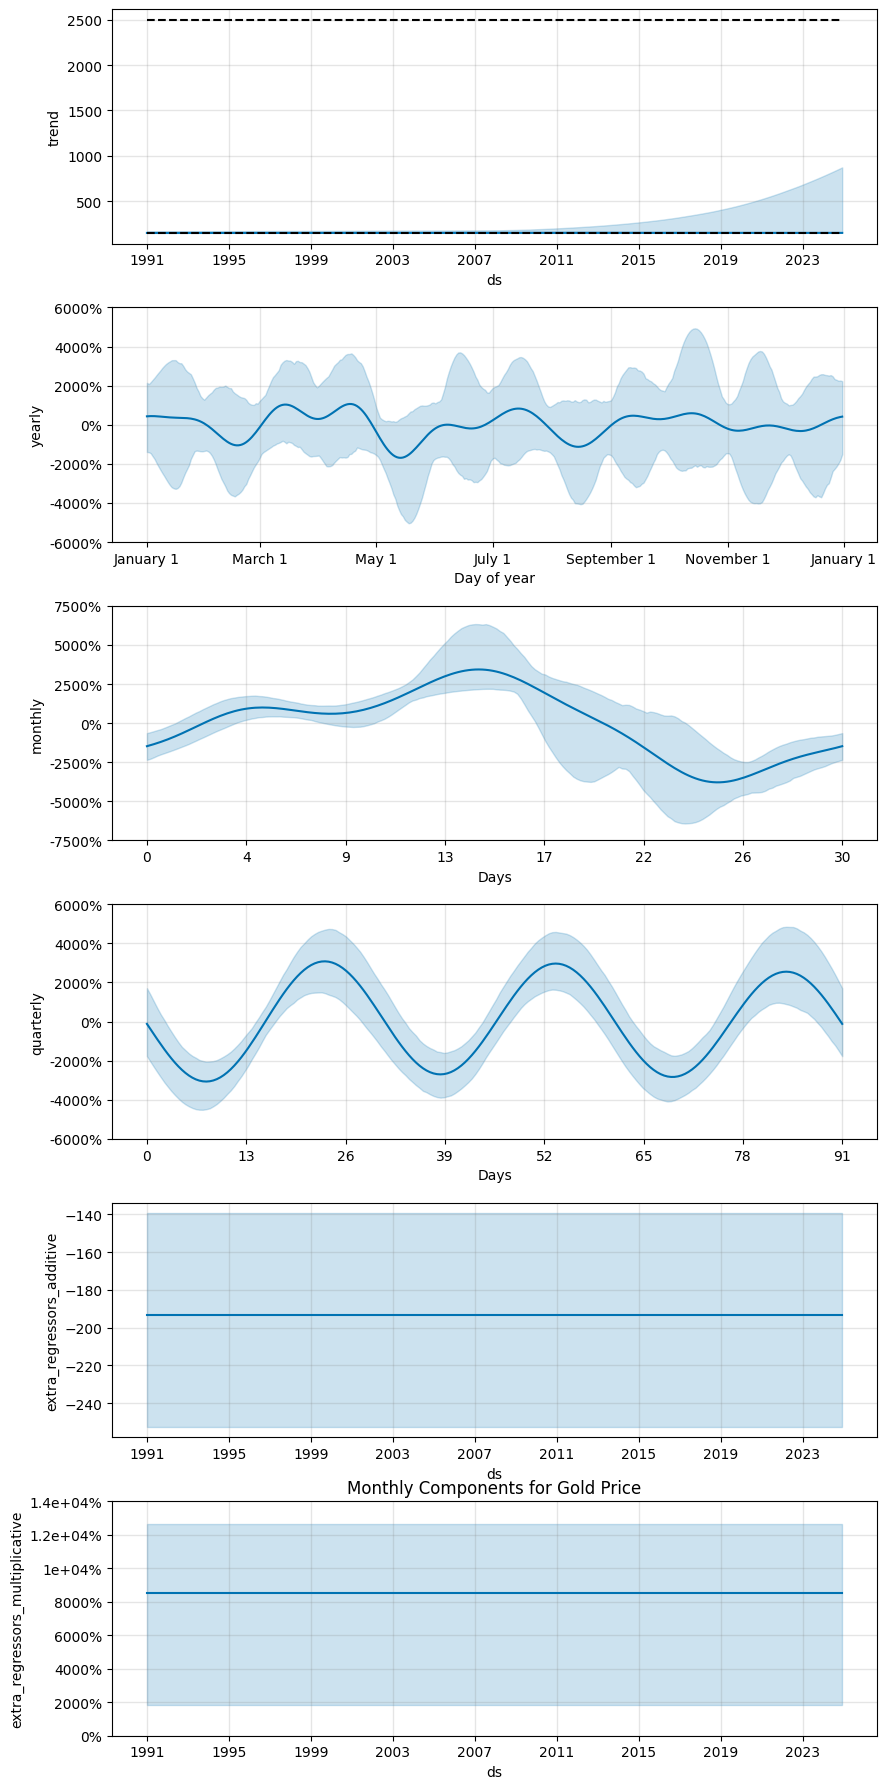

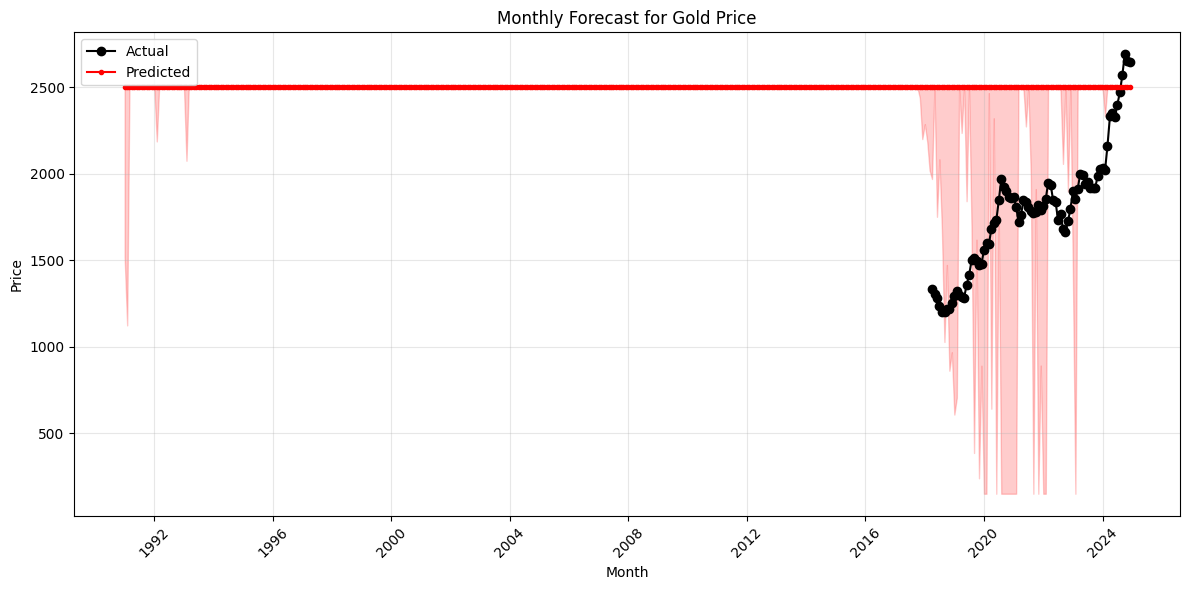

In [12]:
# Enhanced monthly visualization
fig = model.plot_components(forecast)
ax = fig.gca()
ax.set_title(f'Monthly Components for {commodity}')
# plt.savefig(f'monthly_components_{commodity.replace(" ", "_")}.png')
plt.show()

# Monthly actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_df['date'], test_df[commodity], 'ko-', label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], 'r.-', label='Predicted')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='r', alpha=0.2)
plt.title(f'Monthly Forecast for {commodity}')
plt.xlabel('Month')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig(f'monthly_forecast_{commodity.replace(" ", "_")}.png')
plt.show()

In [13]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1993-02-01,7328.882553,-1417.050531,18572.798685,329.31,1993-01-01
1,1993-03-01,3722.031045,-6812.997823,15709.775036,330.08,1993-01-01
2,1993-04-01,5770.872636,-4880.748796,17578.614323,342.15,1993-01-01
3,1993-05-01,3996.410573,-6984.642453,16879.161986,367.18,1993-01-01
4,1993-06-01,5638.862878,-5732.798649,18397.108967,371.89,1993-01-01



Monthly MAPE Breakdown:
month
1     1255.783632
2     1323.513683
3     1213.398102
4     1257.982809
5     1213.909058
6     1274.829900
7     1247.440421
8     1302.276174
9     1317.949840
10    1281.621044
11    1298.742437
12    1270.450784
dtype: float64


/var/folders/rd/tqc_535n6bb2mkqrf4_7nf6w0000gn/T/ipykernel_8379/885817107.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_mape = df.groupby('month', group_keys=False).apply(


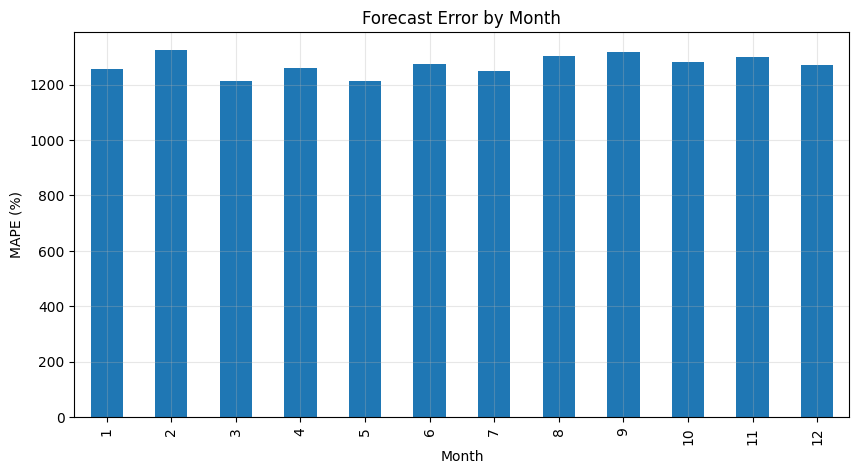


Overall Metrics:
    horizon           mse         rmse          mae       mape      mdape  \
0   59 days  6.248099e+07  7904.491844  7089.653495  13.426504  10.276148   
1   60 days  6.208211e+07  7879.219869  7040.203997  12.943628  10.384898   
2   62 days  5.965121e+07  7723.419882  6883.683812  12.723366   9.930737   
3   90 days  6.085454e+07  7800.931963  6987.163724  13.027348  10.156761   
4   91 days  6.058699e+07  7783.764569  6951.799733  12.742875   8.588693   
5   92 days  6.089093e+07  7803.264154  6959.508635  12.985617   8.288097   
6  120 days  6.020048e+07  7758.897090  6909.922667  12.627589   9.854522   
7  121 days  6.004998e+07  7749.192316  6877.064151  12.339170   8.523092   
8  123 days  6.040207e+07  7771.876828  6910.511116  12.560907   9.884064   
9  151 days  6.246218e+07  7903.301910  7064.535931  12.998377  10.126777   
10 152 days  6.247713e+07  7904.247713  7044.767494  12.777610  10.126777   
11 153 days  6.282543e+07  7926.249148  7055.648652  12.93

In [14]:
# Monthly-focused performance metrics
def monthly_performance_metrics(df: pd.DataFrame, show_plot=True):
    """Enhanced version with visualization"""
    df['month'] = df['ds'].dt.month
    monthly_mape = df.groupby('month', group_keys=False).apply(
        lambda x: calculate_mape(x['y'], x['yhat'])
    )
    
    print("\nMonthly MAPE Breakdown:")
    print(monthly_mape)
    
    if show_plot:
        plt.figure(figsize=(10, 5))
        monthly_mape.plot(kind='bar')
        plt.title('Forecast Error by Month')
        plt.ylabel('MAPE (%)')
        plt.xlabel('Month')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    print("\nOverall Metrics:")
    print(performance_metrics(df))


monthly_performance_metrics(df_cv)